In [ ]:
# ------ This code is to delete files from directory -----
import os
def delete_files_in_directory(directory_path):
   try:
     files = os.listdir(directory_path)
     for file in files:
       file_path = os.path.join(directory_path, file)
       if os.path.isfile(file_path):
         os.remove(file_path)
     print("Deleted successfully !")
   except OSError:
     print("Error !")



##### Step 1 - Import all libraries and define paths

In [ ]:
# --------- Library imports -------------
import cv2
import numpy as np  
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
import numpy as np
from PIL import Image, ImageOps
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures, Direction, DirectionalFinderType
from pathlib import Path

current_path = Path().resolve()   #/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/Final_Drive
pdf_data = os.path.join(current_path, 'pdf_data','Geisinger_Health_Plans.pdf')
pdf_out = os.path.join(current_path, 'pdf_out')
meta_data = os.path.join(current_path, 'meta_data')


##### Step 2 - Convert PDF -> Image Pages 

In [7]:
# Step 2 - Divide the pdf into image pages
from pdf2image import convert_from_path
images = convert_from_path(pdf_data)
for i in range(len(images)):
    images[i].save(os.path.join(pdf_out, 'page'+ str(i) +'.jpg'))

##### Step 3 - Read pages and extract tables from it - CV2 Operations

98 98 1480 1995


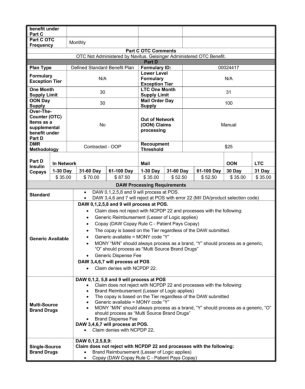

In [24]:
# --------- Preprocessing of images -------------
img_path = os.path.join(pdf_out, 'page2.jpg')
img = cv2.imread(img_path, 0)
#Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite(os.path.join(meta_data,'preprocessed_page','Step1.Image_bin.jpg'),img_bin)
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
cv2.imwrite(os.path.join(meta_data,'preprocessed_page','Step2.verticle_lines.jpg'),verticle_lines_img)
#plt.imshow(verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)

horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

cv2.imwrite(os.path.join(meta_data,'preprocessed_page','Step3.horizontal_lines.jpg'),horizontal_lines_img)
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite(os.path.join(meta_data,'preprocessed_page','Step4.img_final_bin.jpg'),img_final_bin)

#---------- Detecting tables in whole image
original = img.copy()
gray = img_final_bin
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 7)
    print(x,y,w,h)

    ROI = img[y:y+h, x:x+w]

    cv2.imwrite(os.path.join(meta_data,'detected_tables_in_page',f'Table_{ROI_number}.jpg'), ROI)
    ROI_number += 1

#----------------

verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)


#-----------------
cv2.imwrite(os.path.join(meta_data,'preprocessed_page',"Step5.img_table_detect.jpg"),original)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()